In [2]:
import pandas as pd
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_loader import load_data

df = load_data()

for cname, series in df.iloc[:,:-3].items():
    print(cname, series.unique())


gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


In [3]:
from sklearn.model_selection import train_test_split
from src.data_loader import load_data
from src.preprocessing import get_preprocessor

X = df.iloc[:,:-3]
y = df.iloc[:,-3:].mean(axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

preprocessor = get_preprocessor()

X_train_lr = preprocessor.fit_transform(X_train)
X_test_lr = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_lr, columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(X_test_lr, columns = feature_names, index = X_test.index)


Estimating linear regression model using OLS

In [4]:
import statsmodels.api as sm


X_train_df = sm.add_constant(X_train_df)

model = sm.OLS(y_train, X_train_df)
result = model.fit()
print(result.summary())

pred_y_lr = result.predict(sm.add_constant(X_test_df))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     32.50
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           2.48e-44
Time:                        09:39:28   Log-Likelihood:                -3139.7
No. Observations:                 800   AIC:                             6297.
Df Residuals:                     791   BIC:                             6340.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


CatBoost model implementation

In [6]:
from catboost import CatBoostRegressor

#categorical columns
cat_features = X.columns.to_list()


# setting hyperparameters 

# with our small dataset (1000 samples) it is needed to prevent model from overfitting.
# To this end, small number of trees' depth and learning rate along with early stopping of algorithm have been implemented

model = CatBoostRegressor(
    iterations = 1000,
    learning_rate = 0.03,
    depth = 6, 
    loss_function = 'RMSE',
    eval_metric='MAE',
    random_seed=42,
    verbose=100, 
    early_stopping_rounds=50
)


model.fit(
    X_train, y_train, 
    cat_features = cat_features, 
    eval_set = (X_test, y_test), 
    use_best_model = True
)

0:	learn: 11.2344513	test: 11.5889138	best: 11.5889138 (0)	total: 230ms	remaining: 3m 49s
100:	learn: 9.5729760	test: 10.5182321	best: 10.5182321 (100)	total: 5.18s	remaining: 46.1s
200:	learn: 9.2132276	test: 10.4811414	best: 10.4773548 (198)	total: 9.52s	remaining: 37.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.47735482
bestIteration = 198

Shrink model to first 199 iterations.


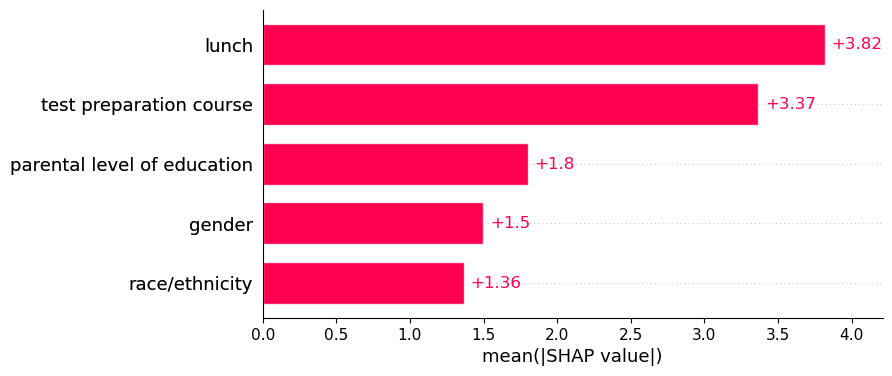

In [10]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

Models comparision

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def stat(real, pred):
    return (r2_score(real, pred), mean_squared_error(real, pred), mean_absolute_percentage_error(real, pred), mean_absolute_error(real, pred))

pred_y_ct = model.predict(X_test)

comparision = pd.DataFrame({
    'OLS': stat(y_test, pred_y_lr),
    'CB': stat(y_test, pred_y_ct),
},
index = ['R2', 'MSE', 'MAPE', 'MAE']
)
print(comparision.round(2))

         OLS      CB
R2      0.18    0.16
MSE   176.31  179.17
MAPE    0.21    0.21
MAE    10.39   10.48


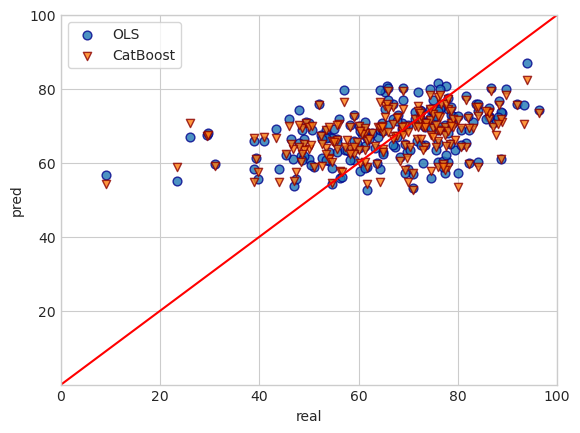

In [11]:
import matplotlib.pyplot as plt
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.xlim(0, 100)  
    plt.ylim(0, 100)  
    plt.scatter(y_test, pred_y_lr, s = 40, alpha = 0.8, label = 'OLS', edgecolors = 'darkblue')
    plt.scatter(y_test, pred_y_ct, s = 35, alpha = 0.8, marker = 'v', label = 'CatBoost', edgecolors = 'darkred')
    plt.plot([0, 102], [0, 102], c = 'r')
    plt.xlabel('real')
    plt.ylabel('pred')
    plt.yticks(np.arange(20, 101, 20))
    plt.legend(frameon = True)

In [ ]:
import joblib
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

joblib.dump(full_pipeline, '../models/student_performance_pipeline.joblib')

['../models/student_performance_pipeline.joblib']